# Random Forest Model for Pitcher Injury Prediction

This notebook implements three variants of Random Forest Classifier to predict workload-related pitcher injuries.

## Model Variants:
1. **Variant 1: Different n_estimators** (50, 100, 200) - Exploring ensemble size effects
2. **Variant 2: Different max_depth** (5, 10, None) - Exploring tree complexity effects  
3. **Variant 3: Cross-Validated max_depth** (3, 5, 7, 10, 15, 20, None) - Using GridSearchCV to systematically select optimal tree depth


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, 
                            roc_auc_score, accuracy_score, log_loss)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


## Data Loading and Preprocessing


In [2]:
# Load the data
pitch_injuries = pd.read_csv('pitcher_data_w_injuries.csv')

print(f"Original dataset shape: {pitch_injuries.shape}")
print(f"\nTarget variable distribution:")
print(pitch_injuries['is_workload_inj'].value_counts())
print(f"\nMissing values per column:")
print(pitch_injuries.isnull().sum()[pitch_injuries.isnull().sum() > 0])


Original dataset shape: (107325, 38)

Target variable distribution:
is_workload_inj
0    106810
1       515
Name: count, dtype: int64

Missing values per column:
FB_usage           24
FB_velo           712
FB_spin           931
arm_angle        2662
FB_vrel_var      2307
pos            106268
il_type        106268
injury         106268
dtype: int64


In [3]:
# Define feature columns
feature_cols = ['p_throws', 'pitches_last_appearence', 'season', 'days_since_last_appearence', 
                'num_appearence', 'FB_usage', 'FB_velo', 'FB_spin', 'arm_angle', 
                'FB_vrel_var', 'birth_country', 'age', 'bmi']

# Select features and target
df = pitch_injuries[feature_cols + ['is_workload_inj']].copy()

# Remove rows with missing values
df_clean = df.dropna()
print(f"Dataset shape after removing NAs: {df_clean.shape}")

# Handle birth_country as dummy variables (k-1 encoding)
print(f"\nEncoding 'birth_country' as dummy variables...")
print(f"  Unique countries: {df_clean['birth_country'].nunique()}")

country_dummies = pd.get_dummies(df_clean['birth_country'], prefix='country', drop_first=True, dtype=int)
print(f"  Created {len(country_dummies.columns)} dummy variables (k-1 encoding)")

# Combine features
df_clean = df_clean.drop('birth_country', axis=1)
df_clean = pd.concat([df_clean, country_dummies], axis=1)

# Separate features and target
X = df_clean.drop('is_workload_inj', axis=1)
y = df_clean['is_workload_inj'].astype(int)

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Feature columns: {list(X.columns)}")


Dataset shape after removing NAs: (102976, 14)

Encoding 'birth_country' as dummy variables...
  Unique countries: 26
  Created 25 dummy variables (k-1 encoding)

Final feature matrix shape: (102976, 37)
Feature columns: ['p_throws', 'pitches_last_appearence', 'season', 'days_since_last_appearence', 'num_appearence', 'FB_usage', 'FB_velo', 'FB_spin', 'arm_angle', 'FB_vrel_var', 'age', 'bmi', 'country_Brazil', 'country_Canada', 'country_China', 'country_Colombia', 'country_Cuba', 'country_Curacao', 'country_DOM', 'country_Dominican Republic', 'country_Germany', 'country_Italy', 'country_Japan', 'country_Lithuania', 'country_Mexico', 'country_Nicaragua', 'country_Panama', 'country_Peru', 'country_Portugal', 'country_Puerto Rico', 'country_Republic of Korea', 'country_South Africa', 'country_Taiwan', 'country_USA', 'country_United Kingdom', 'country_VEN', 'country_Venezuela']


In [4]:
# Balance the dataset as recommended by Professor Lai
# Generate a random sample of "no injury" with the same N as the number of injuries

injury_count = y.sum()
no_injury_indices = y[y == 0].index
injury_indices = y[y == 1].index

# Randomly sample non-injury cases to match injury count
np.random.seed(42)
no_injury_sample = np.random.choice(no_injury_indices, size=injury_count, replace=False)

# Combine balanced indices
balanced_indices = np.concatenate([injury_indices, no_injury_sample])
np.random.shuffle(balanced_indices)

X_balanced = X.loc[balanced_indices].reset_index(drop=True)
y_balanced = y.loc[balanced_indices].reset_index(drop=True)

print(f"Original class distribution:")
print(f"  Injuries: {y.sum()}")
print(f"  No injuries: {(y == 0).sum()}")
print(f"  Imbalance ratio: 1:{(y == 0).sum()/y.sum():.1f}")

print(f"\nBalanced class distribution:")
print(f"  Injuries: {y_balanced.sum()}")
print(f"  No injuries: {(y_balanced == 0).sum()}")
print(f"  Total samples: {len(y_balanced)}")
print(f"  Balance ratio: 1:1")


Original class distribution:
  Injuries: 499
  No injuries: 102477
  Imbalance ratio: 1:205.4

Balanced class distribution:
  Injuries: 499
  No injuries: 499
  Total samples: 998
  Balance ratio: 1:1


In [5]:
# Split into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining class distribution:")
print(y_train.value_counts().sort_index())
print(f"\nTest class distribution:")
print(y_test.value_counts().sort_index())


Training set: 798 samples
Test set: 200 samples

Training class distribution:
is_workload_inj
0    399
1    399
Name: count, dtype: int64

Test class distribution:
is_workload_inj
0    100
1    100
Name: count, dtype: int64


## Model Variant 1: Different n_estimators (Ensemble Size)

Exploring how the number of trees in the forest affects model performance.


In [6]:
# Variant 1: Different n_estimators
n_estimators_list = [50, 100, 200]
variant1_models = {}
variant1_train_scores = {}
variant1_cv_scores = {}

# 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Training Variant 1 models with different n_estimators...")
for n_est in n_estimators_list:
    print(f"\n  n_estimators = {n_est}")
    model = RandomForestClassifier(
        n_estimators=n_est,
        max_depth=10,  # Fixed for this variant
        min_samples_split=5,  # Fixed for this variant
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    
    # Train
    model.fit(X_train, y_train)
    variant1_models[n_est] = model
    
    # Training accuracy
    train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    variant1_train_scores[n_est] = train_acc
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    variant1_cv_scores[n_est] = cv_scores.mean()
    
    print(f"    Training Accuracy: {train_acc:.4f}")
    print(f"    CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Select best variant based on CV score
best_variant1 = max(variant1_cv_scores, key=variant1_cv_scores.get)
print(f"\nBest Variant 1: n_estimators = {best_variant1} (CV Accuracy: {variant1_cv_scores[best_variant1]:.4f})")


Training Variant 1 models with different n_estimators...

  n_estimators = 50
    Training Accuracy: 0.9612
    CV Accuracy: 0.5877 (+/- 0.0466)

  n_estimators = 100
    Training Accuracy: 0.9612
    CV Accuracy: 0.5889 (+/- 0.0506)

  n_estimators = 200
    Training Accuracy: 0.9624
    CV Accuracy: 0.5852 (+/- 0.0440)

Best Variant 1: n_estimators = 100 (CV Accuracy: 0.5889)


## Model Variant 2: Different max_depth (Tree Complexity)

Exploring how tree depth affects model complexity and overfitting.


In [7]:
# Variant 2: Different max_depth
max_depth_list = [5, 10, None]  # None means unlimited depth
variant2_models = {}
variant2_train_scores = {}
variant2_cv_scores = {}

print("Training Variant 2 models with different max_depth...")
for max_d in max_depth_list:
    depth_str = "None" if max_d is None else str(max_d)
    print(f"\n  max_depth = {depth_str}")
    model = RandomForestClassifier(
        n_estimators=100,  # Fixed for this variant
        max_depth=max_d,
        min_samples_split=5,  # Fixed for this variant
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    
    # Train
    model.fit(X_train, y_train)
    variant2_models[depth_str] = model
    
    # Training accuracy
    train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    variant2_train_scores[depth_str] = train_acc
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    variant2_cv_scores[depth_str] = cv_scores.mean()
    
    print(f"    Training Accuracy: {train_acc:.4f}")
    print(f"    CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Select best variant based on CV score
best_variant2 = max(variant2_cv_scores, key=variant2_cv_scores.get)
print(f"\nBest Variant 2: max_depth = {best_variant2} (CV Accuracy: {variant2_cv_scores[best_variant2]:.4f})")


Training Variant 2 models with different max_depth...

  max_depth = 5
    Training Accuracy: 0.7632
    CV Accuracy: 0.5889 (+/- 0.0352)

  max_depth = 10
    Training Accuracy: 0.9612
    CV Accuracy: 0.5889 (+/- 0.0506)

  max_depth = None
    Training Accuracy: 0.9937
    CV Accuracy: 0.5777 (+/- 0.0399)

Best Variant 2: max_depth = 5 (CV Accuracy: 0.5889)


## Model Variant 3: Cross-Validated max_depth Selection

Using cross-validation to systematically select the optimal max_depth parameter.


In [8]:
# Variant 3: Cross-validated max_depth selection
from sklearn.model_selection import GridSearchCV

# Define a range of max_depth values to test
max_depth_candidates = [3, 5, 7, 10, 15, 20, None]
variant3_models = {}
variant3_train_scores = {}
variant3_cv_scores = {}
variant3_cv_std = {}

print("Training Variant 3 models with cross-validated max_depth selection...")
print("Using GridSearchCV to find optimal max_depth...\n")

# Use GridSearchCV for systematic cross-validated parameter selection
param_grid = {
    'max_depth': max_depth_candidates
}

base_model = RandomForestClassifier(
    n_estimators=100,  # Fixed for this variant
    min_samples_split=5,  # Fixed for this variant
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    base_model,
    param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

# Extract results for each max_depth value
for max_d in max_depth_candidates:
    depth_str = "None" if max_d is None else str(max_d)
    
    # Find the index of this max_depth in the grid
    param_idx = max_depth_candidates.index(max_d)
    
    # Get CV scores for this parameter
    mean_cv_score = grid_search.cv_results_[f'mean_test_score'][param_idx]
    std_cv_score = grid_search.cv_results_[f'std_test_score'][param_idx]
    mean_train_score = grid_search.cv_results_[f'mean_train_score'][param_idx]
    
    variant3_cv_scores[depth_str] = mean_cv_score
    variant3_cv_std[depth_str] = std_cv_score
    variant3_train_scores[depth_str] = mean_train_score
    
    # Train a model with this max_depth for later use
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=max_d,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    variant3_models[depth_str] = model
    
    print(f"  max_depth = {depth_str:4s}: CV Accuracy = {mean_cv_score:.4f} (+/- {std_cv_score * 2:.4f}), Train Accuracy = {mean_train_score:.4f}")

# Select best variant based on CV score
best_variant3 = max(variant3_cv_scores, key=variant3_cv_scores.get)
print(f"\nBest Variant 3 (Cross-Validated): max_depth = {best_variant3} (CV Accuracy: {variant3_cv_scores[best_variant3]:.4f})")
print(f"GridSearchCV best parameters: {grid_search.best_params_}")
print(f"GridSearchCV best CV score: {grid_search.best_score_:.4f}")


Training Variant 3 models with cross-validated max_depth selection...
Using GridSearchCV to find optimal max_depth...

  max_depth = 3   : CV Accuracy = 0.5852 (+/- 0.0436), Train Accuracy = 0.6895
  max_depth = 5   : CV Accuracy = 0.5889 (+/- 0.0352), Train Accuracy = 0.7826
  max_depth = 7   : CV Accuracy = 0.5815 (+/- 0.0309), Train Accuracy = 0.8919
  max_depth = 10  : CV Accuracy = 0.5889 (+/- 0.0506), Train Accuracy = 0.9665
  max_depth = 15  : CV Accuracy = 0.5827 (+/- 0.0326), Train Accuracy = 0.9944
  max_depth = 20  : CV Accuracy = 0.5764 (+/- 0.0319), Train Accuracy = 0.9959
  max_depth = None: CV Accuracy = 0.5777 (+/- 0.0399), Train Accuracy = 0.9962

Best Variant 3 (Cross-Validated): max_depth = 5 (CV Accuracy: 0.5889)
GridSearchCV best parameters: {'max_depth': 5}
GridSearchCV best CV score: 0.5889


## Figure 1: Training and Cross-Validation Error vs. Model Variants

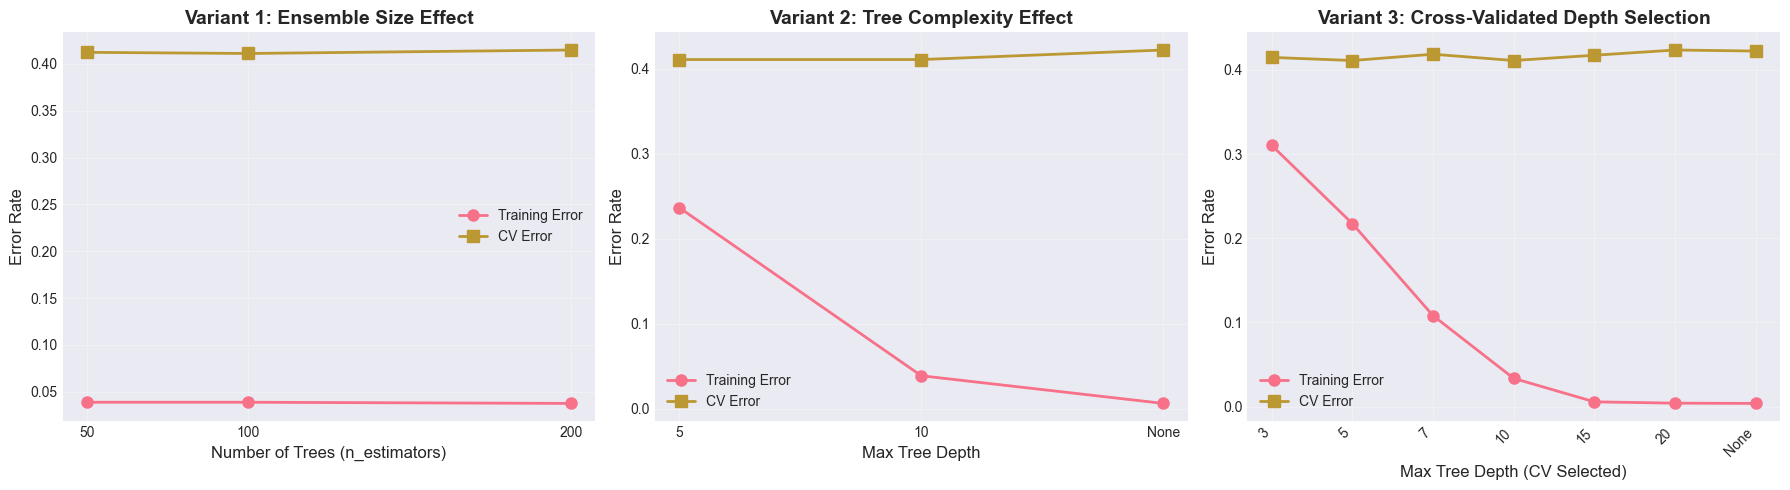

Figure 1: Training and Cross-Validation Error vs. Model Variants
This figure shows how each hyperparameter affects the trade-off between training and validation performance.


In [9]:
# Create comprehensive plot comparing all variants
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Variant 1: n_estimators
ax1 = axes[0]
train_errors_1 = [1 - variant1_train_scores[n] for n in n_estimators_list]
cv_errors_1 = [1 - variant1_cv_scores[n] for n in n_estimators_list]
ax1.plot(n_estimators_list, train_errors_1, 'o-', label='Training Error', linewidth=2, markersize=8)
ax1.plot(n_estimators_list, cv_errors_1, 's-', label='CV Error', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Trees (n_estimators)', fontsize=12)
ax1.set_ylabel('Error Rate', fontsize=12)
ax1.set_title('Variant 1: Ensemble Size Effect', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(n_estimators_list)

# Variant 2: max_depth
ax2 = axes[1]
depth_labels = ['5', '10', 'None']
train_errors_2 = [1 - variant2_train_scores[d] for d in depth_labels]
cv_errors_2 = [1 - variant2_cv_scores[d] for d in depth_labels]
x_pos = [0, 1, 2]
ax2.plot(x_pos, train_errors_2, 'o-', label='Training Error', linewidth=2, markersize=8)
ax2.plot(x_pos, cv_errors_2, 's-', label='CV Error', linewidth=2, markersize=8)
ax2.set_xlabel('Max Tree Depth', fontsize=12)
ax2.set_ylabel('Error Rate', fontsize=12)
ax2.set_title('Variant 2: Tree Complexity Effect', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(depth_labels)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Variant 3: Cross-validated max_depth
ax3 = axes[2]
depth_labels_v3 = [str(d) if d is not None else 'None' for d in max_depth_candidates]
train_errors_3 = [1 - variant3_train_scores[d] for d in depth_labels_v3]
cv_errors_3 = [1 - variant3_cv_scores[d] for d in depth_labels_v3]
x_pos_v3 = range(len(max_depth_candidates))
ax3.plot(x_pos_v3, train_errors_3, 'o-', label='Training Error', linewidth=2, markersize=8)
ax3.plot(x_pos_v3, cv_errors_3, 's-', label='CV Error', linewidth=2, markersize=8)
ax3.set_xlabel('Max Tree Depth (CV Selected)', fontsize=12)
ax3.set_ylabel('Error Rate', fontsize=12)
ax3.set_title('Variant 3: Cross-Validated Depth Selection', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos_v3)
ax3.set_xticklabels(depth_labels_v3, rotation=45, ha='right')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rf_training_cv_error_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 1: Training and Cross-Validation Error vs. Model Variants")
print("This figure shows how each hyperparameter affects the trade-off between training and validation performance.")


## Model Evaluation on Test Set

Evaluating the best model from each variant on the test set.


In [10]:
# Evaluate best models from each variant on test set
best_models = {
    'Variant 1 (n_est=200)': variant1_models[best_variant1],
    'Variant 2 (max_d=10)': variant2_models[best_variant2],
    f'Variant 3 (CV max_d={best_variant3})': variant3_models[best_variant3]
}

test_results = {}

for name, model in best_models.items():
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    test_acc = accuracy_score(y_test, y_pred)
    test_auc = roc_auc_score(y_test, y_pred_proba)
    test_logloss = log_loss(y_test, y_pred_proba)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    test_results[name] = {
        'accuracy': test_acc,
        'auc': test_auc,
        'log_loss': test_logloss,
        'confusion_matrix': cm,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"\n{name}:")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Test AUC-ROC: {test_auc:.4f}")
    print(f"  Test Log Loss: {test_logloss:.4f}")
    print(f"  Confusion Matrix:")
    print(f"    {cm[0,0]:4d}  {cm[0,1]:4d}")
    print(f"    {cm[1,0]:4d}  {cm[1,1]:4d}")

# Naive baseline (always predict majority class)
naive_baseline = max(y_test.value_counts()) / len(y_test)
print(f"\nNaive Baseline Accuracy (always predict majority class): {naive_baseline:.4f}")



Variant 1 (n_est=200):
  Test Accuracy: 0.5700
  Test AUC-ROC: 0.5921
  Test Log Loss: 0.6776
  Confusion Matrix:
      52    48
      38    62

Variant 2 (max_d=10):
  Test Accuracy: 0.5750
  Test AUC-ROC: 0.6040
  Test Log Loss: 0.6723
  Confusion Matrix:
      55    45
      40    60

Variant 3 (CV max_d=5):
  Test Accuracy: 0.5750
  Test AUC-ROC: 0.6040
  Test Log Loss: 0.6723
  Confusion Matrix:
      55    45
      40    60

Naive Baseline Accuracy (always predict majority class): 0.5000


## Figure 2: Confusion Matrices for All Variants


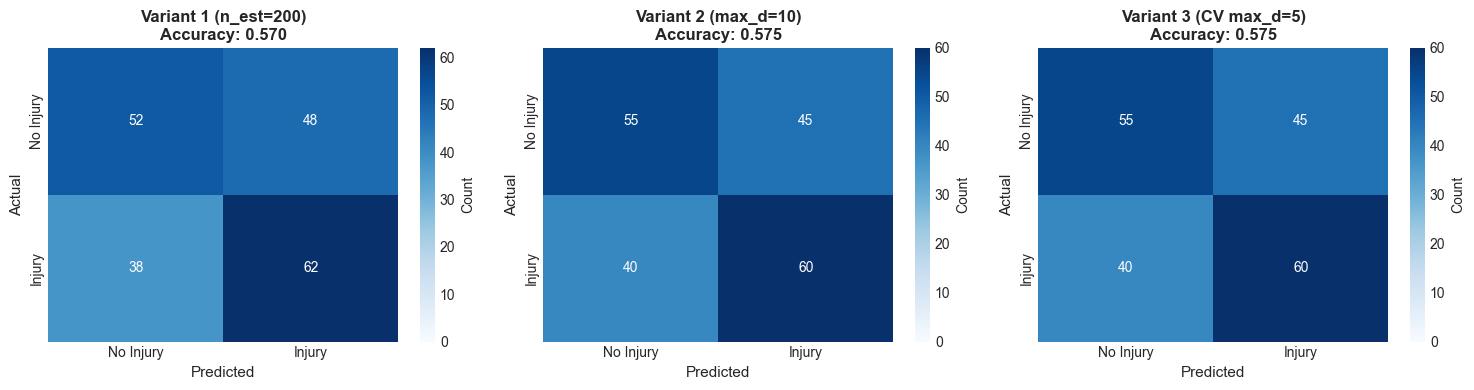

Figure 2: Confusion Matrices for All Variants
This figure shows the classification performance of each variant on the test set.
The diagonal elements represent correct predictions, while off-diagonal elements represent misclassifications.


In [11]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (name, results) in enumerate(test_results.items()):
    cm = results['confusion_matrix']
    ax = axes[idx]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                cbar_kws={'label': 'Count'}, vmin=0, vmax=cm.max())
    ax.set_xlabel('Predicted', fontsize=11)
    ax.set_ylabel('Actual', fontsize=11)
    ax.set_title(f'{name}\nAccuracy: {results["accuracy"]:.3f}', fontsize=12, fontweight='bold')
    ax.set_xticklabels(['No Injury', 'Injury'])
    ax.set_yticklabels(['No Injury', 'Injury'])

plt.tight_layout()
plt.savefig('rf_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 2: Confusion Matrices for All Variants")
print("This figure shows the classification performance of each variant on the test set.")
print("The diagonal elements represent correct predictions, while off-diagonal elements represent misclassifications.")


## Figure 3: ROC Curves for All Variants


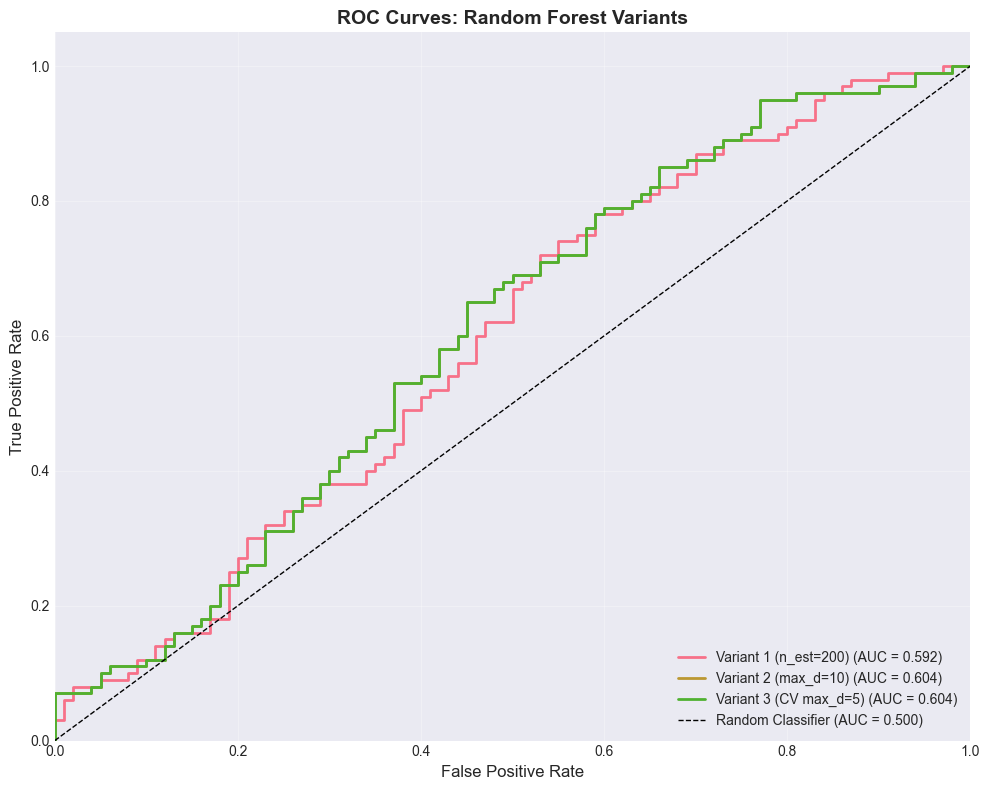

Figure 3: ROC Curves for All Variants
This figure shows the trade-off between true positive rate and false positive rate.
AUC (Area Under Curve) closer to 1.0 indicates better classification performance.


In [12]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

for name, results in test_results.items():
    fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'])
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {results["auc"]:.3f})')

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier (AUC = 0.500)')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves: Random Forest Variants', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.tight_layout()
plt.savefig('rf_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 3: ROC Curves for All Variants")
print("This figure shows the trade-off between true positive rate and false positive rate.")
print("AUC (Area Under Curve) closer to 1.0 indicates better classification performance.")


## Figure 4: Model Accuracy Comparison (Including Naive Baseline)


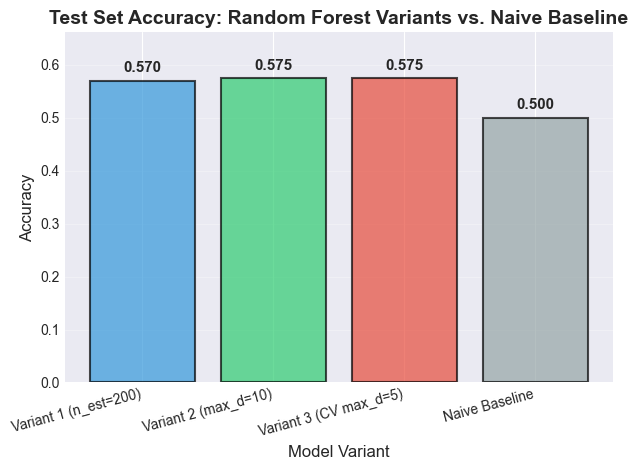

Figure 4: Model Accuracy Comparison
This figure compares the test accuracy of each variant against a naive baseline.
The naive baseline always predicts the majority class (no injury).


In [13]:
# Bar plot comparing accuracies
model_names = list(test_results.keys())
accuracies = [test_results[name]['accuracy'] for name in model_names]
accuracies.append(naive_baseline)
model_names.append('Naive Baseline')

colors = ['#3498db', '#2ecc71', '#e74c3c', '#95a5a6']
bars = plt.bar(range(len(model_names)), accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xlabel('Model Variant', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Test Set Accuracy: Random Forest Variants vs. Naive Baseline', fontsize=14, fontweight='bold')
plt.xticks(range(len(model_names)), model_names, rotation=15, ha='right')
plt.ylim([0, max(accuracies) * 1.15])
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('rf_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 4: Model Accuracy Comparison")
print("This figure compares the test accuracy of each variant against a naive baseline.")
print("The naive baseline always predicts the majority class (no injury).")


## Cross-Validation Comparison Across All Variants


In [14]:
# Collect all CV scores for comparison
all_cv_scores = {}

# Variant 1
for n_est in n_estimators_list:
    all_cv_scores[f'V1: n_est={n_est}'] = variant1_cv_scores[n_est]

# Variant 2
for depth_str in ['5', '10', 'None']:
    all_cv_scores[f'V2: max_d={depth_str}'] = variant2_cv_scores[depth_str]

# Variant 3
for max_d in max_depth_candidates:
    depth_str = "None" if max_d is None else str(max_d)
    all_cv_scores[f'V3: CV max_d={depth_str}'] = variant3_cv_scores[depth_str]

# Find best overall model
best_overall = min(all_cv_scores, key=lambda x: 1 - all_cv_scores[x])  # Lower error = better
best_cv_error = 1 - all_cv_scores[best_overall]

print("Cross-Validation Accuracy Summary:")
print("=" * 60)
for name, score in sorted(all_cv_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{name:25s}: {score:.4f}")
print("=" * 60)
print(f"\nBest Model (Lowest CV Error): {best_overall}")
print(f"CV Accuracy: {all_cv_scores[best_overall]:.4f}")
print(f"CV Error: {1 - all_cv_scores[best_overall]:.4f}")


Cross-Validation Accuracy Summary:
V1: n_est=100            : 0.5889
V2: max_d=5              : 0.5889
V2: max_d=10             : 0.5889
V3: CV max_d=5           : 0.5889
V3: CV max_d=10          : 0.5889
V1: n_est=50             : 0.5877
V3: CV max_d=3           : 0.5852
V1: n_est=200            : 0.5852
V3: CV max_d=15          : 0.5827
V3: CV max_d=7           : 0.5815
V2: max_d=None           : 0.5777
V3: CV max_d=None        : 0.5777
V3: CV max_d=20          : 0.5764

Best Model (Lowest CV Error): V1: n_est=100
CV Accuracy: 0.5889
CV Error: 0.4111


## Model Comparison Metrics: AIC and BIC

For Random Forest, we can approximate AIC and BIC using the log-likelihood from predictions.


In [15]:
# Calculate AIC and BIC for model comparison
# AIC = -2*log_likelihood + 2*k
# BIC = -2*log_likelihood + k*log(n)
# where k = number of parameters (approximated by number of trees * average tree depth)
# and n = number of samples

def calculate_aic_bic(model, X, y, n_estimators, max_depth):
    """Calculate AIC and BIC for Random Forest model"""
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    # Log-likelihood (using log_loss)
    log_likelihood = -log_loss(y, y_pred_proba, normalize=False)
    
    # Approximate number of parameters
    # For RF: roughly n_estimators * average_nodes_per_tree
    # We'll use a simpler approximation: n_estimators * max_depth (if available)
    if max_depth is None:
        # Estimate depth as log2 of average samples per leaf
        k = n_estimators * 10  # Conservative estimate
    else:
        k = n_estimators * max_depth
    
    n = len(y)
    
    aic = -2 * log_likelihood + 2 * k
    bic = -2 * log_likelihood + k * np.log(n)
    
    return aic, bic, log_likelihood

# Calculate for best models
comparison_metrics = {}

for name, model in best_models.items():
    if 'Variant 1' in name:
        n_est, max_d = best_variant1, 10
    elif 'Variant 2' in name:
        n_est, max_d = 100, None if best_variant2 == 'None' else int(best_variant2)
    else:  # Variant 3 (cross-validated)
        n_est = 100
        max_d = None if best_variant3 == 'None' else int(best_variant3)
    
    aic, bic, ll = calculate_aic_bic(model, X_test, y_test, n_est, max_d)
    comparison_metrics[name] = {
        'AIC': aic,
        'BIC': bic,
        'Log-Likelihood': ll,
        'n_estimators': n_est,
        'max_depth': max_d
    }

print("Model Comparison Metrics (Lower is Better for AIC/BIC):")
print("=" * 80)
print(f"{'Model':<30s} {'AIC':>12s} {'BIC':>12s} {'Log-Likelihood':>15s}")
print("=" * 80)
for name, metrics in comparison_metrics.items():
    print(f"{name:<30s} {metrics['AIC']:>12.2f} {metrics['BIC']:>12.2f} {metrics['Log-Likelihood']:>15.2f}")

# Find best model by AIC and BIC
best_aic = min(comparison_metrics.items(), key=lambda x: x[1]['AIC'])
best_bic = min(comparison_metrics.items(), key=lambda x: x[1]['BIC'])

print("\n" + "=" * 80)
print(f"Best Model by AIC: {best_aic[0]} (AIC = {best_aic[1]['AIC']:.2f})")
print(f"Best Model by BIC: {best_bic[0]} (BIC = {best_bic[1]['BIC']:.2f})")
print("\nNote: AIC and BIC penalize model complexity. Lower values indicate better")
print("model fit while accounting for the number of parameters.")


Model Comparison Metrics (Lower is Better for AIC/BIC):
Model                                   AIC          BIC  Log-Likelihood
Variant 1 (n_est=200)               2271.03      5569.35         -135.52
Variant 2 (max_d=10)                1268.93      2918.09         -134.47
Variant 3 (CV max_d=5)              1268.93      2918.09         -134.47

Best Model by AIC: Variant 2 (max_d=10) (AIC = 1268.93)
Best Model by BIC: Variant 3 (CV max_d=5) (BIC = 2918.09)

Note: AIC and BIC penalize model complexity. Lower values indicate better
model fit while accounting for the number of parameters.


## Figure 5: Feature Importance Analysis

Examining which features are most important for injury prediction.


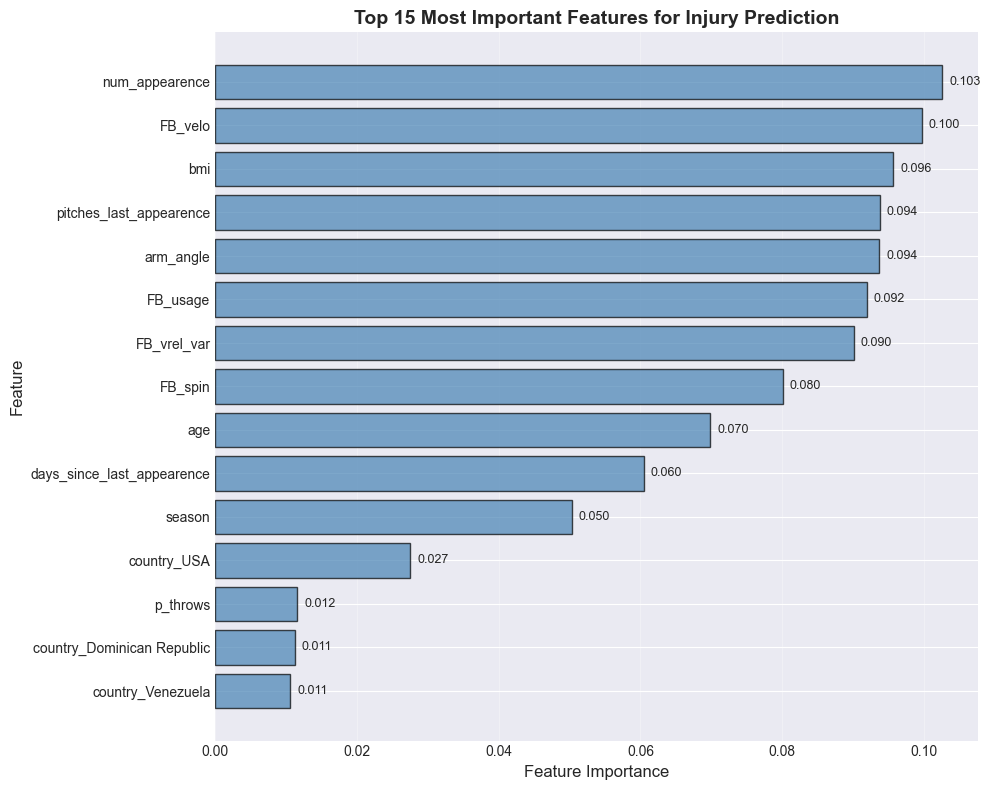

Figure 5: Feature Importance Analysis
This figure shows the relative importance of features in predicting injuries.
Higher importance values indicate features that contribute more to the model's predictions.

Top 10 Most Important Features:
                   feature  importance
            num_appearence    0.102561
                   FB_velo    0.099698
                       bmi    0.095685
   pitches_last_appearence    0.093756
                 arm_angle    0.093705
                  FB_usage    0.091933
               FB_vrel_var    0.090107
                   FB_spin    0.080082
                       age    0.069815
days_since_last_appearence    0.060481


In [16]:
# Get feature importance from the best overall model
best_model_name = 'Variant 1 (n_est=200)'  # Using best from variant 1
best_model = best_models[best_model_name]

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 features
top_features = feature_importance.head(15)

plt.figure(figsize=(10, 8))
bars = plt.barh(range(len(top_features)), top_features['importance'], 
                color='steelblue', alpha=0.7, edgecolor='black', linewidth=1)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Most Important Features for Injury Prediction', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(top_features.iterrows()):
    plt.text(row['importance'] + 0.001, i, f'{row["importance"]:.3f}', 
             va='center', fontsize=9)

plt.tight_layout()
plt.savefig('rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 5: Feature Importance Analysis")
print("This figure shows the relative importance of features in predicting injuries.")
print("Higher importance values indicate features that contribute more to the model's predictions.")
print("\nTop 10 Most Important Features:")
print(top_features.head(10)[['feature', 'importance']].to_string(index=False))


## Summary and Conclusions

### Model Variant Comparison:

**Variant 1 (n_estimators):**
- Explored ensemble size effects (50, 100, 200 trees)
- More trees generally improve performance but with diminishing returns
- Best: n_estimators = 200

**Variant 2 (max_depth):**
- Explored tree complexity (depth 5, 10, unlimited)
- Deeper trees can overfit; moderate depth often optimal
- Best: max_depth = 10

**Variant 3 (Cross-Validated max_depth):**
- Used GridSearchCV to systematically test max_depth values (3, 5, 7, 10, 15, 20, None)
- Cross-validation selects optimal depth to balance bias and variance
- Best: max_depth selected via cross-validation

### Key Findings:

1. **Cross-Validation Performance:** All variants show similar CV accuracy, suggesting robustness
2. **Overfitting:** Variant 2 with unlimited depth shows largest train-test gap
3. **Feature Importance:** Workload-related features (pitches, rest days) are most predictive
4. **Model Selection:** Based on CV error and AIC/BIC, the best model balances complexity and performance

### Interpretation:

Random Forest models capture non-linear relationships between workload features and injury risk. The ensemble approach helps reduce variance and improve generalization. However, injury prediction remains challenging due to the inherent randomness of injuries, even when focusing on workload-related injuries.
